In [1]:
import numpy as np
import torch

from torchvision.utils import draw_bounding_boxes

import lib.visualizations as visualizations
import tensorflow_datasets as tfds

from data import MOVI

/home/user/villar/anaconda3/envs/VideoPred/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import tensorflow_datasets as tfds
from tqdm import tqdm
import pickle

In [8]:
from data._Movi import _MoviC

In [9]:
db = _MoviC(split="validation", num_frames=30, img_size=(64, 64), slot_initializer="BBox")

Loading MOVI-C validation set...


In [22]:
all_data = next(db.db)

In [63]:
imgs = torch.from_numpy(all_data["video"]).permute(0, 3, 1, 2) / 255
# imgs = self.resizer(imgs).float()

In [64]:
minv, maxv = all_data["metadata"]["forward_flow_range"]
forward_flow = all_data["forward_flow"] / 65535 * (maxv - minv) + minv

flow_rgb = visualizations.flow_to_rgb(forward_flow)
flow_rgb = torch.from_numpy(flow_rgb).permute(0, 3, 1, 2)

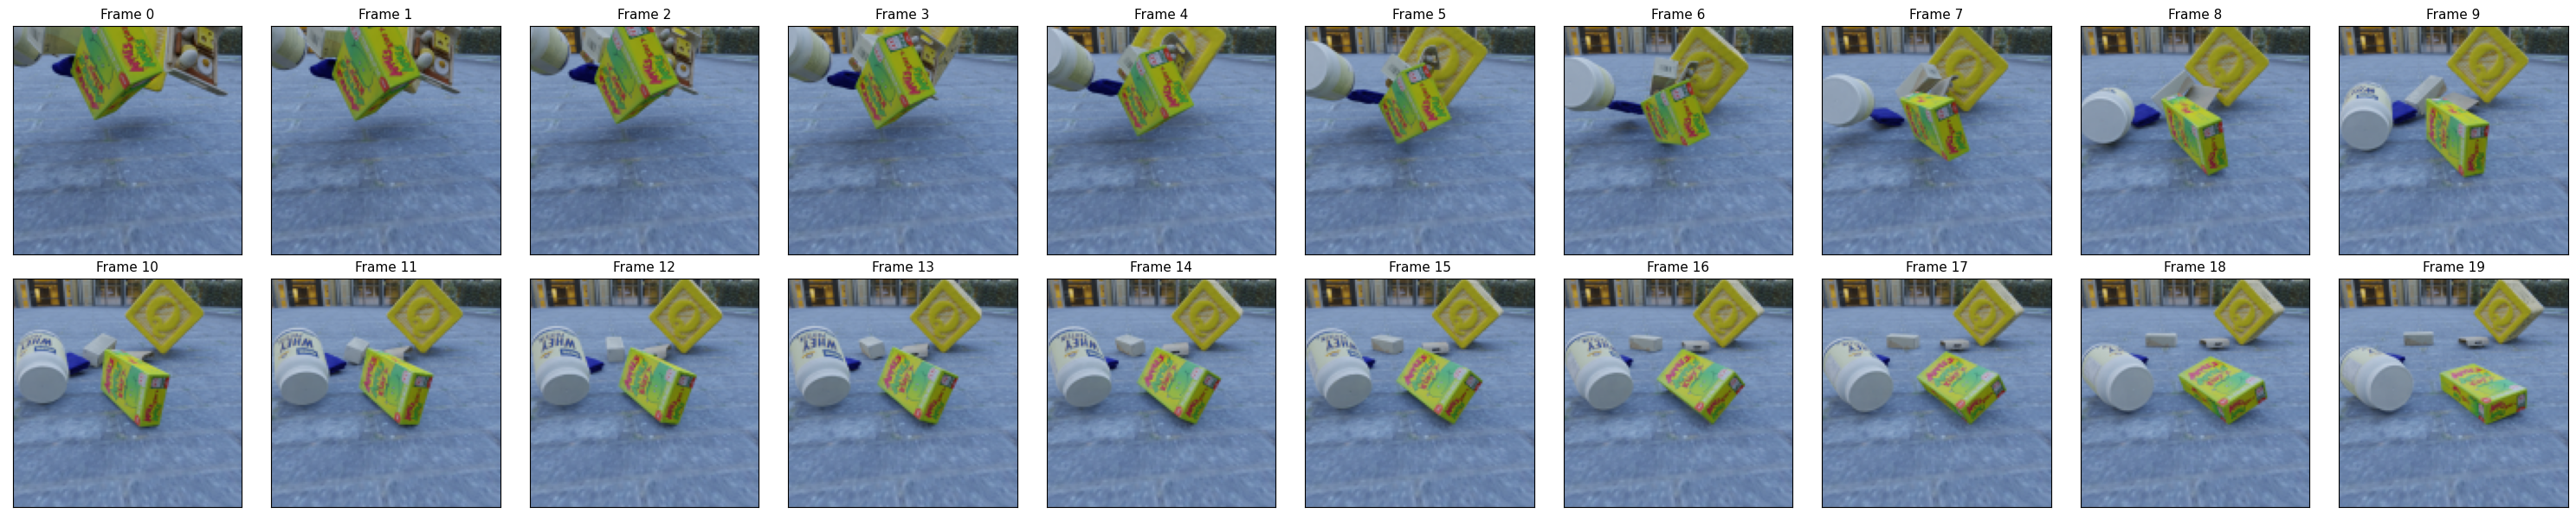

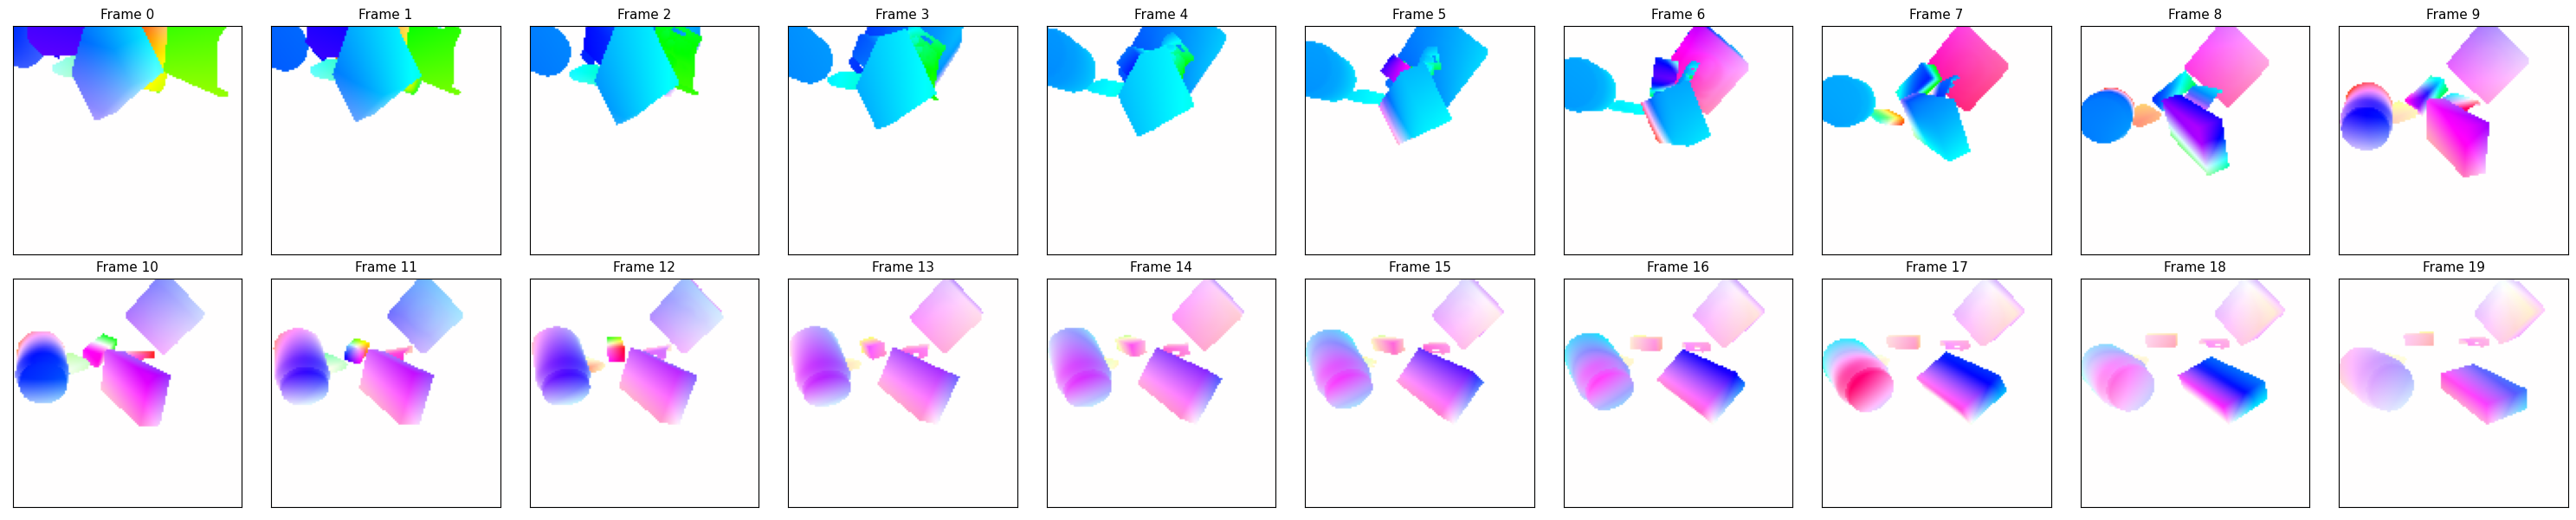

In [65]:
_ = visualizations.visualize_sequence(imgs[:20])
_ = visualizations.visualize_sequence(flow_rgb[:20])

In [56]:
from matplotlib import colors
def flow_tensor_to_rgb_tensor(flow, flow_scaling_factor=50.):
    """Visualizes flow motion image as an RGB image.
    Similar as the flow_to_rgb function, but with tensors.
    Args:
    motion_image: A tensor either of shape [batch_sz, height, width, 2] or of
      shape [height, width, 2]. motion_image[..., 0] is flow in x and
      motion_image[..., 1] is flow in y.
    flow_scaling_factor: How much to scale flow for visualization.
    Returns:
    A visualization tensor with same shape as motion_image, except with three
    channels. The dtype of the output is tf.uint8.
    """

    hypot = lambda a, b: (a ** 2.0 + b ** 2.0) ** 0.5  # sqrt(a^2 + b^2)

    height, width = flow.shape[-3], flow.shape[-2]
    scaling = flow_scaling_factor / hypot(height, width)
    x, y = flow[..., 0], flow[..., 1]
    motion_angle = np.arctan2(y, x)
    motion_angle = (motion_angle / np.math.pi + 1.0) / 2.0
    motion_magnitude = hypot(y, x)
    motion_magnitude = np.clip(motion_magnitude * scaling, 0.0, 1.0)
    value_channel = np.ones_like(motion_angle)
    flow_hsv = np.stack([motion_angle, motion_magnitude, value_channel], axis=-1)
    flow_rgb = colors.hsv_to_rgb(flow_hsv)
    return flow_rgb

In [57]:
c = flow_tensor_to_rgb_tensor(forward_flow)
c = torch.from_numpy(c).permute(0, 3, 1, 2)

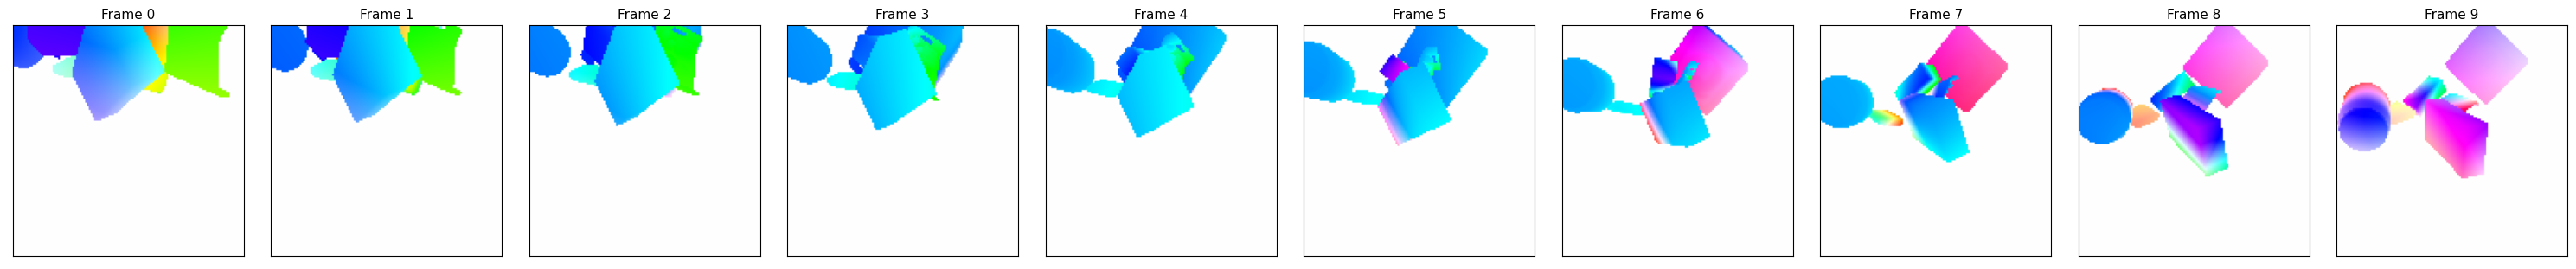

In [58]:
_ = visualizations.visualize_sequence(c[:10])

In [17]:
all_data.keys()

dict_keys(['background', 'backward_flow', 'camera', 'depth', 'events', 'forward_flow', 'instances', 'metadata', 'normal', 'object_coordinates', 'segmentations', 'video'])

In [48]:
datapath = "/home/nfs/inf6/data/datasets/MOVi/movi_c"

db = MOVI(datapath=datapath, target="rgb", split="validation", num_frames=10, img_size=(64, 64))
db.get_masks = False
db.get_rgb = True
db.get_flow = True
db.get_bbox = True

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 11937.48it/s]


In [49]:
len(db)

250

In [61]:
video, all_reps = db[2]
flow = all_reps["flow"]

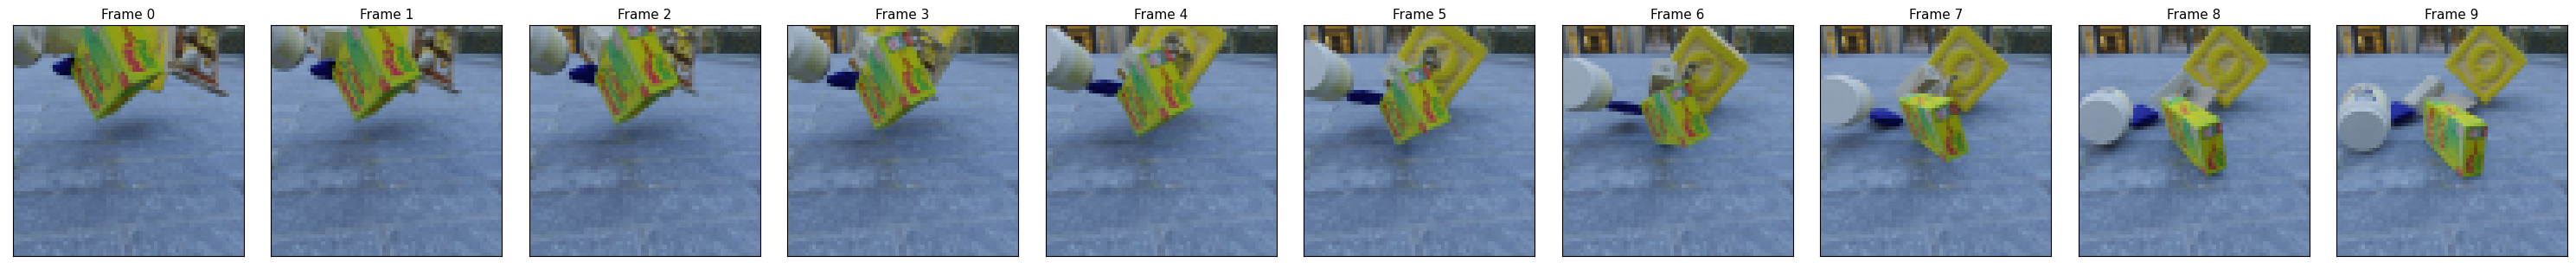

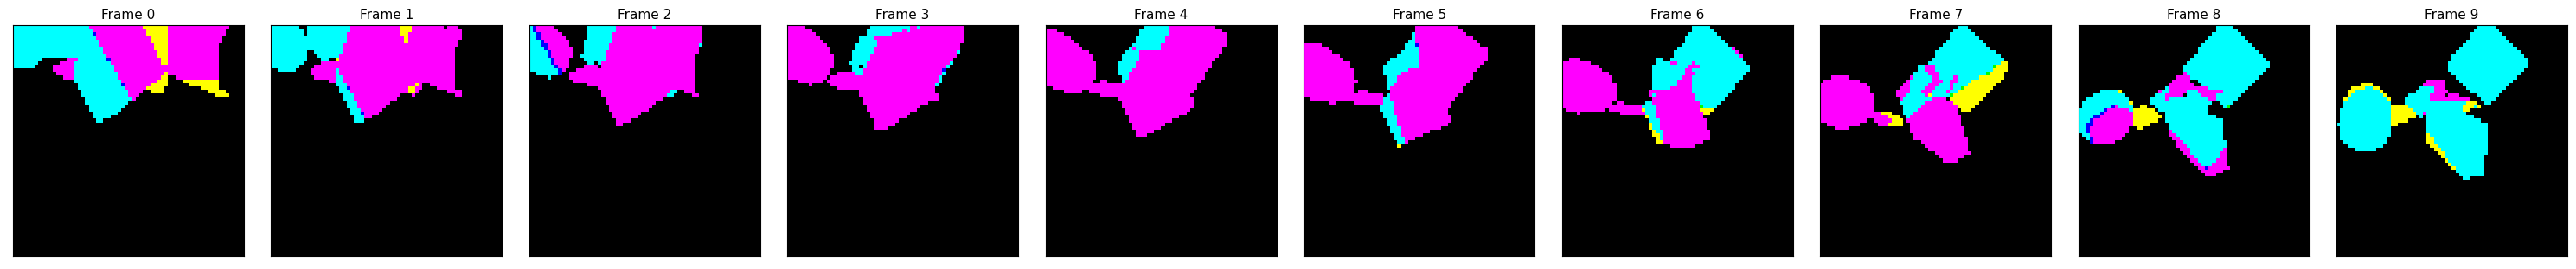

In [62]:
_ = visualizations.visualize_sequence(video[:10])
_ = visualizations.visualize_sequence(flow[:10])

In [64]:
# segmetation = all_reps["masks"]
# segmentation_rgb = visualizations.masks_to_rgb(segmetation)
# _ = visualizations.visualize_sequence(segmentation_rgb[:10])

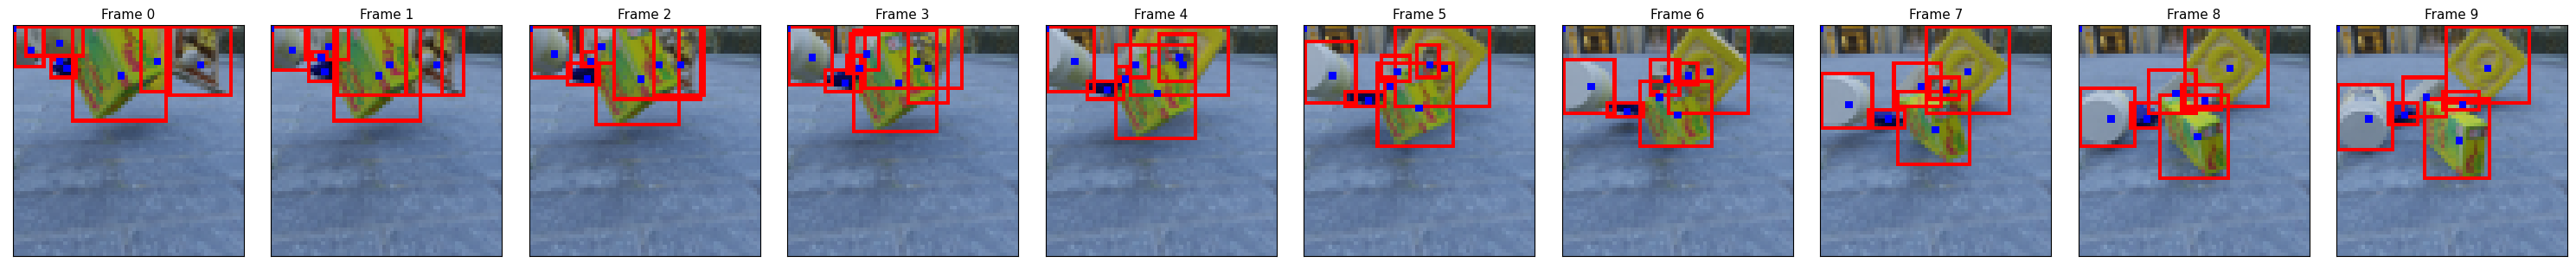

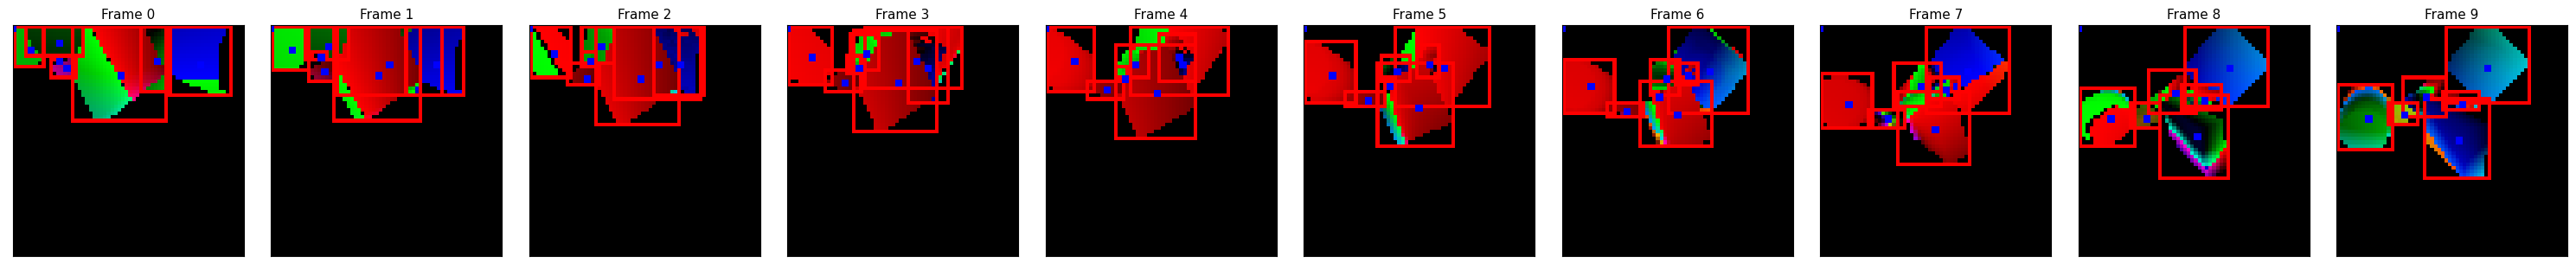

In [65]:
bbox = all_reps["bbox_coords"]
com = all_reps["com_coords"]

# adding bounding boxes
imgs_disp = torch.stack([
        draw_bounding_boxes(image=(video[i] * 255).to(torch.uint8), boxes=bbox[i], colors="red", width=1)
    for i in range(10)])
flow_disp = torch.stack([
        draw_bounding_boxes(image=(flow[i] * 255).to(torch.uint8), boxes=bbox[i], colors="red", width=1)
    for i in range(10)])

# adding centers of mass
com_disp = torch.stack([com[..., 0], com[..., 1], com[..., 0]+1, com[..., 1]+1], dim=-1)
imgs_disp = torch.stack([
        draw_bounding_boxes(image=(imgs_disp[i]).to(torch.uint8), boxes=com_disp[i], colors="blue", width=1)
    for i in range(10)])
flow_disp = torch.stack([
        draw_bounding_boxes(image=(flow_disp[i]).to(torch.uint8), boxes=com_disp[i], colors="blue", width=1)
    for i in range(10)])

_ = visualizations.visualize_sequence(imgs_disp / 255)
_ = visualizations.visualize_sequence(flow_disp / 255)

In [34]:
video.shape


torch.Size([10, 3, 64, 64])

In [32]:
bbox.max()

tensor(127.)